In [1]:
# Libraries and helpers

# Librarires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
import gspread

# Set up repo root path
import os
os.chdir("../..")

# Helpers
from src import config
from src import help_functions as hf
from analysis.history_aware_relative_stratified_training_load import config as sub_config

# Configs
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [2]:
# Get Training data

user = "urh"
user_config = config.USER_CONFIGURATIONS[user]

googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(
    googleDrive_client=googleDrive_client, 
    filename=user_config["gdrive_activity_log_filename"], 
    sheet_name=config.BASIC_ACTIVITY_STATISTICS_SHEET_NAME
    )

training_data = hf.data_safe_convert_to_numeric(training_data)

In [3]:
# Get HASR-TL data

user = "urh"
user_config = config.USER_CONFIGURATIONS[user]

googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
hasr_tl_data, _ = hf.import_google_sheet(
    googleDrive_client=googleDrive_client, 
    filename=user_config["gdrive_activity_log_filename"], 
    sheet_name=sub_config.HASR_TL_SHEET_NAME
    )

hasr_tl_data = hf.data_safe_convert_to_numeric(hasr_tl_data)
hasr_tl_data["Datetime"] = pd.to_datetime(hasr_tl_data[["Year", "Month", "Day"]])

### How do we weight the days? Baseline & Recent

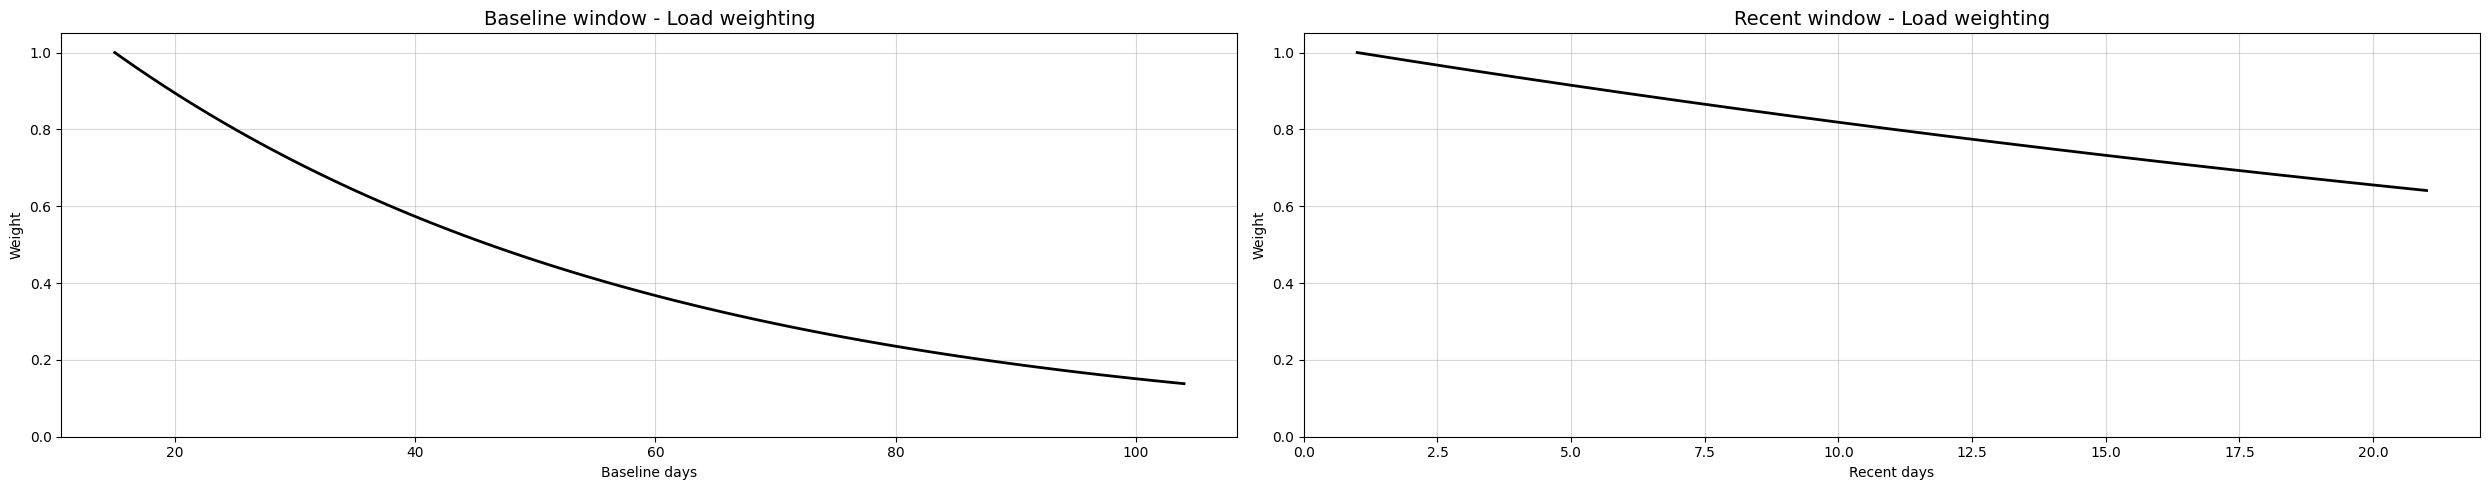

In [4]:
# How do we weight the days?

fig, ax = plt.subplots(1,2, figsize=(25,5))

ax[0].set_title("Baseline window - Load weighting", fontsize=14)
baseline_window_days = range(1, sub_config.BASELINE_WINDOW+1)
baseline_window_weights = np.array([sub_config.LAMBDA_BASE ** (j-1) for j in baseline_window_days])
ax[0].plot(np.repeat(14, 90) + baseline_window_days, baseline_window_weights, color="black", linewidth=2)
ax[0].set_xlabel("Baseline days")


ax[1].set_title("Recent window - Load weighting", fontsize=14)
recent_window_days = range(1, sub_config.RECENT_WINDOW+1)
recent_window_weights = np.array([sub_config.LAMBDA_BASE ** (j-1) for j in recent_window_days])
ax[1].plot(recent_window_days, recent_window_weights, color="black", linewidth=2)
ax[1].set_xlabel("Recent days")

for i in [0,1]:
    ax[i].set_ylim(0,1.05)
    ax[i].set_ylabel("Weight")
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

fig.savefig("analysissaved_filed.png", dpi=150, bbox_inches="tight")

### Training Load distribution ~ Easy, Hard, Long

In [5]:
# Prepare data

rtl_data = (
    training_data
    .assign(Datetime = lambda df: pd.to_datetime(df[["Year", "Month", "Day"]]))
    .groupby("Datetime")
    .agg({
        "Training load": "sum",
        "Distance [km]": "sum",
        "Duration [h]": "sum",
        "Activity type": lambda x: " | ".join(map(str, x)),  
        "Description": lambda x: " | ".join(x)  
    })
    .reset_index()
)

rtl_data["training_type_description"] = pd.Series(dtype="object")

# Rest days
rest_mask = rtl_data["Description"] == "Rest"
rtl_data.loc[rest_mask, "training_type_description"] = "rest"

# Eays days (No special description, duration < 1.5h)
easy_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"].str.contains("Running|Workout|Biking|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) &
    ~(rtl_data["Description"].str.contains("Race", case=False, na=False)) & 
    (rtl_data["training_type_description"].isnull())
)
rtl_data.loc[easy_mask, "training_type_description"] = "easy"

# Hard days (Special description, duration < 2h)
hard_mask = (
    (rtl_data["Duration [h]"] <= 2.0) &
    (rtl_data["Description"] .str.contains("INT|TT|PWH|LT|x")) &
    ~(rtl_data["Description"].str.contains("Running|Biking|Workout|Aerobni|Lahkoten|Hiking|Aktivacija ", case=False, na=False)) & 
    (rtl_data["training_type_description"].isnull())
)
rtl_data.loc[hard_mask, "training_type_description"] = "hard"

# Long days (No special description, duration >= 2h)
long_mask = (
    (rtl_data["Duration [h]"] >= 2.0)  &
    (rtl_data["Description"].str.contains("Running|Dolgi|Tek|x", case=False, na=False)) & 
    (rtl_data["training_type_description"].isnull())
)
rtl_data.loc[long_mask, "training_type_description"] = "long"

# Other (medium long days, other ...)
other_mask = (
    (rtl_data["training_type_description"].isnull())
)
rtl_data.loc[other_mask, "training_type_description"] = "other"

In [6]:
# About
print("Training type - description:")
print("-----------------------------------------------------")
for value in ["easy", "hard", "long", "other", "rest"]:
    data_tmp = rtl_data.query("training_type_description == @value")
    print("{} ~> {} ({}% | *{}%) ~> [mean = {}, SD = {}]".format(
        value, 
        data_tmp.shape[0],
        round(data_tmp.shape[0]/rtl_data.shape[0] * 100, 2),
        round(data_tmp.shape[0]/rtl_data.query("training_type_description != 'rest'").shape[0] * 100, 2),
        round(data_tmp["Training load"].mean(), 2),
        round(data_tmp["Training load"].std(), 2)
        ))
print("* ~> Without rest days included in proportions")

print("\nTraining load Quantile values:")
print("-----------------------------------------------------")
quantile_06 = rtl_data["Training load"].quantile(0.6)
quantile_085 = rtl_data["Training load"].quantile(0.85)
print("Quantile 0.6 = {}".format(round(quantile_06, 1)))
print("Quantile 0.85 = {}".format(round(quantile_085, 1)))

Training type - description:
-----------------------------------------------------
easy ~> 172 (46.74% | *54.26%) ~> [mean = 96.14, SD = 42.98]
hard ~> 52 (14.13% | *16.4%) ~> [mean = 189.49, SD = 55.69]
long ~> 68 (18.48% | *21.45%) ~> [mean = 217.57, SD = 95.37]
other ~> 25 (6.79% | *7.89%) ~> [mean = 130.82, SD = 65.84]
rest ~> 51 (13.86% | *16.09%) ~> [mean = 0.0, SD = 0.0]
* ~> Without rest days included in proportions

Training load Quantile values:
-----------------------------------------------------
Quantile 0.6 = 131.1
Quantile 0.85 = 207.0


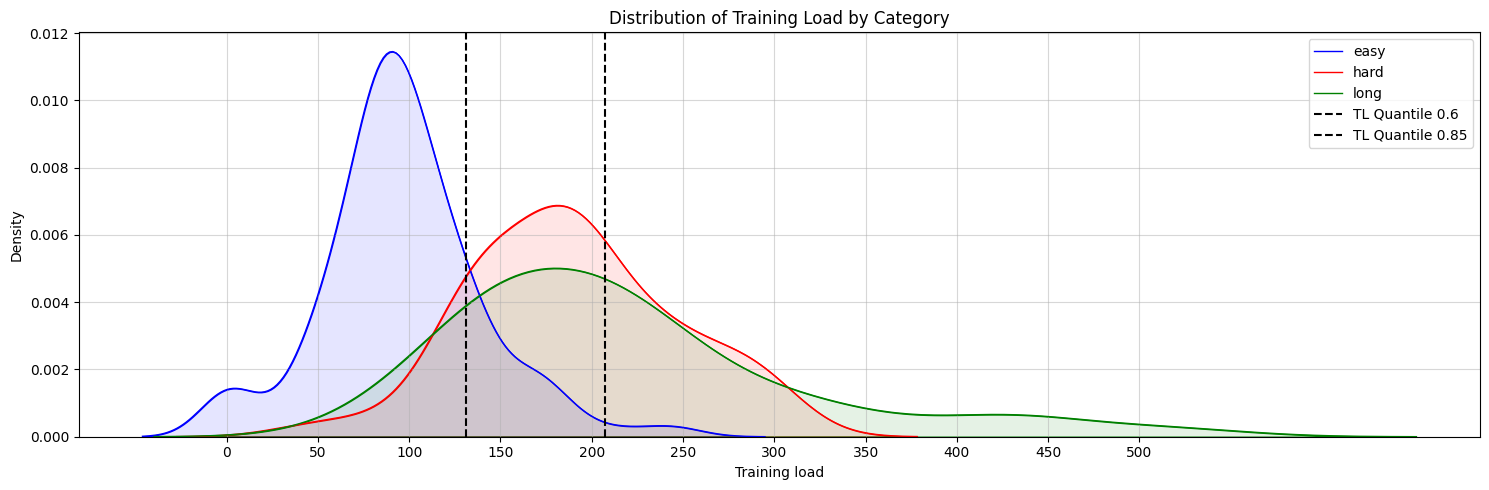

In [ ]:
# Training load distribution
fig, ax = plt.subplots(1,1, figsize=(15,5))

colors = {"easy": "blue", "hard": "red", "long": "green", "other": "grey"}
categories = ["easy", "hard", "long"] # "other"

for cat in categories:
    tmp = rtl_data.query("training_type_description == @cat")["Training load"]
    color = colors[cat]
    sns.kdeplot(tmp, color=color, fill=True, alpha=0.1, ax=ax)
    sns.kdeplot(tmp, color=color, fill=False, alpha=1.0, ax=ax, label=cat, linewidth=1)

ax.axvline(x = quantile_06, color="black", linestyle="--", label = "TL Quantile 0.6")
ax.axvline(x = quantile_085, color="black", linestyle="--", label = "TL Quantile 0.85")

ax.set_xticks(np.arange(0, rtl_data["Training load"].max()+1, step=50))
ax.set_xlabel("Training load")
ax.set_ylabel("Density")
ax.set_title("Distribution of Training Load by Category")
ax.legend()

plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### HASR-TL

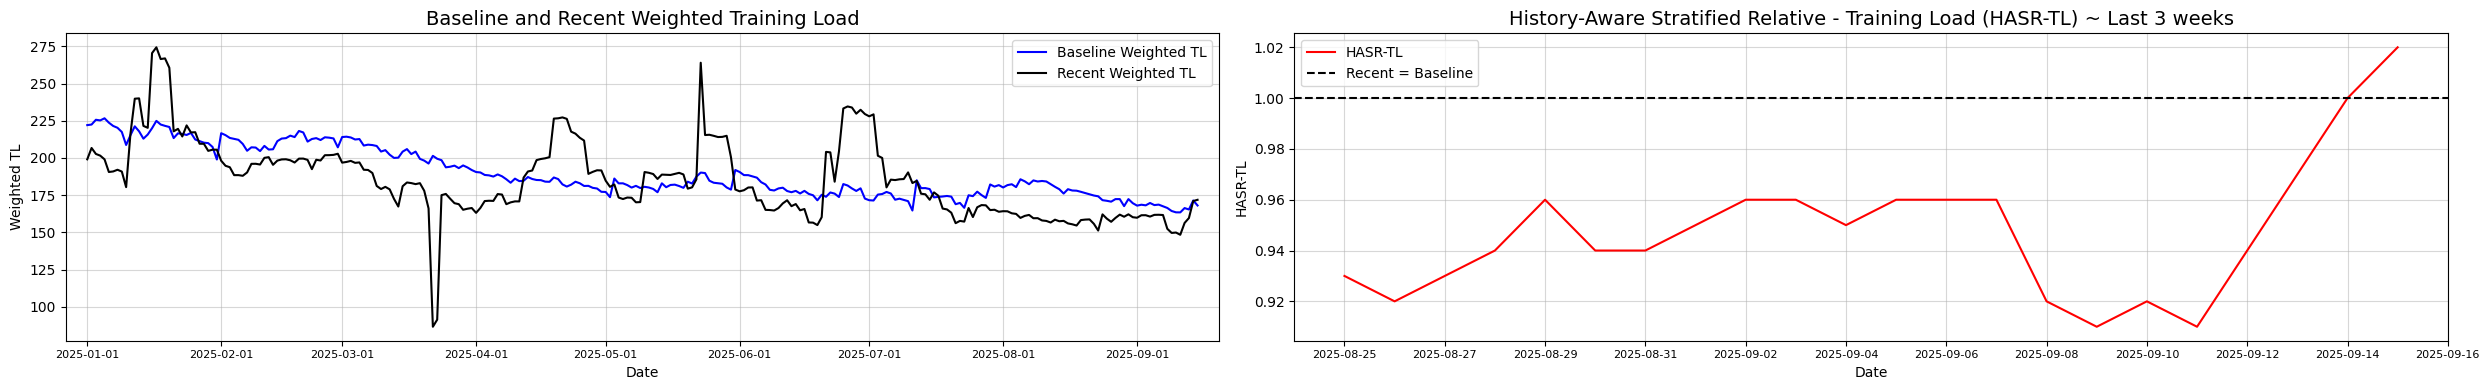

In [13]:
# HASRT-TL ~ Full & Last weeks

fig, ax = plt.subplots(1,2, figsize=(25,4))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0].set_title("Baseline and Recent Weighted Training Load", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.HASR_TL_COLUMN_NAMES[2]], color="blue", label="Baseline Weighted TL")
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.HASR_TL_COLUMN_NAMES[1]], color="black", label="Recent Weighted TL")
ax[0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(hasr_tl_data["Datetime"] + datetime.timedelta(days=5)))
ax[0].set_ylabel("Weighted TL")
ax[0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1].set_title("History-Aware Stratified Relative - Training Load (HASR-TL) ~ Last 3 weeks", fontsize=14)
ax[1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.HASR_TL_COLUMN_NAMES[0]], color="red", label="HASR-TL")
ax[1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1].set_ylabel("HASR-TL")
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Date")
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

### Bucket level diagnostics

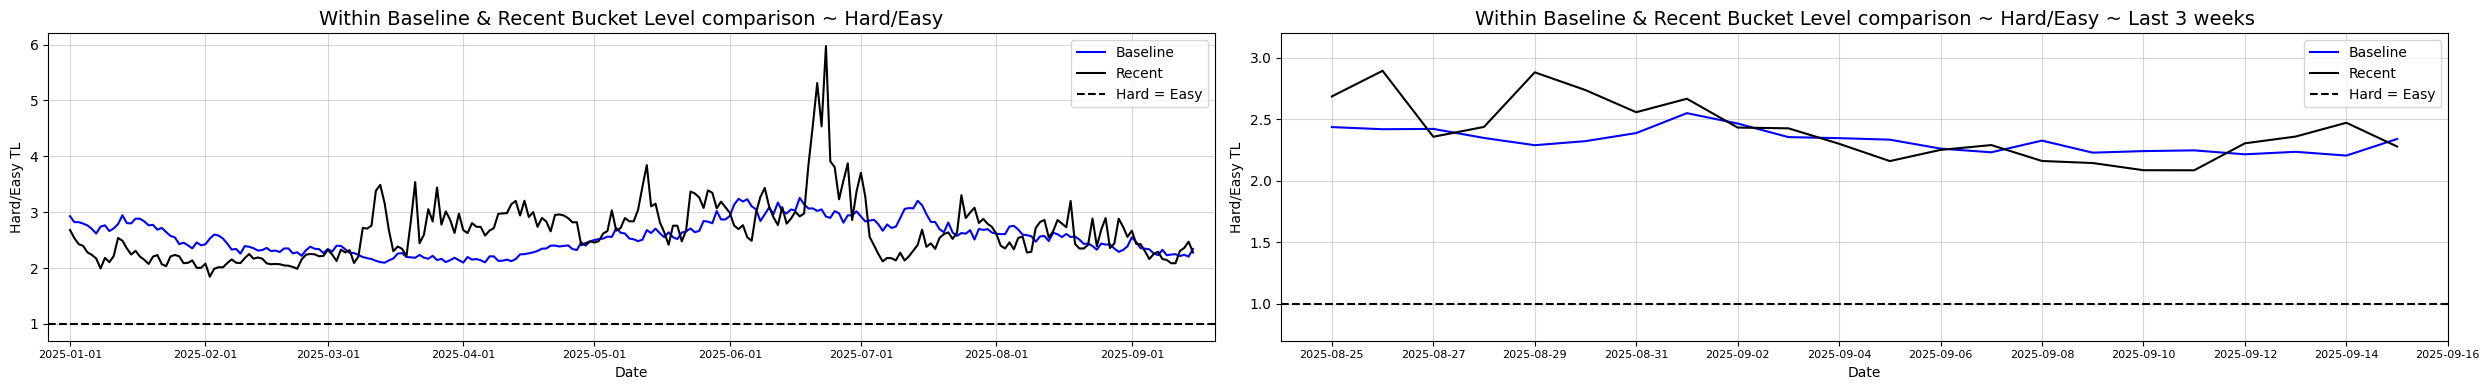

In [39]:
# Within window Bucket level comparison ~ Baseline [Hard vs. Easy] & Recent [Hard vs. Easy]

fig, ax = plt.subplots(1,2, figsize=(25,4))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0].set_title("Within Baseline & Recent Bucket Level comparison ~ Hard/Easy", fontsize=14)
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]] / plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]] / plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]], color="black", label="Recent")
ax[0].set_ylabel("Hard/Easy TL")
ax[0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(hasr_tl_data["Datetime"] + datetime.timedelta(days=5)))
ax[0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax[0].set_ylim(0.7, 6.2)

ax[1].set_title("Within Baseline & Recent Bucket Level comparison ~ Hard/Easy ~ Last 3 weeks", fontsize=14)
ax[1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]] / plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]] / plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]], color="black", label="Recent")
ax[1].set_ylabel("Hard/Easy TL")
ax[1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax[1].set_ylim(0.7, 3.2)

for i in [0,1]:
    ax[i].axhline(y=1, color="black", linestyle="--", label="Hard = Easy")
    ax[i].set_xlabel("Date")
    ax[i].tick_params(axis="x", rotation=0, labelsize=8)
    ax[i].legend()
    ax[i].grid(alpha=0.5)

plt.tight_layout()
plt.show()

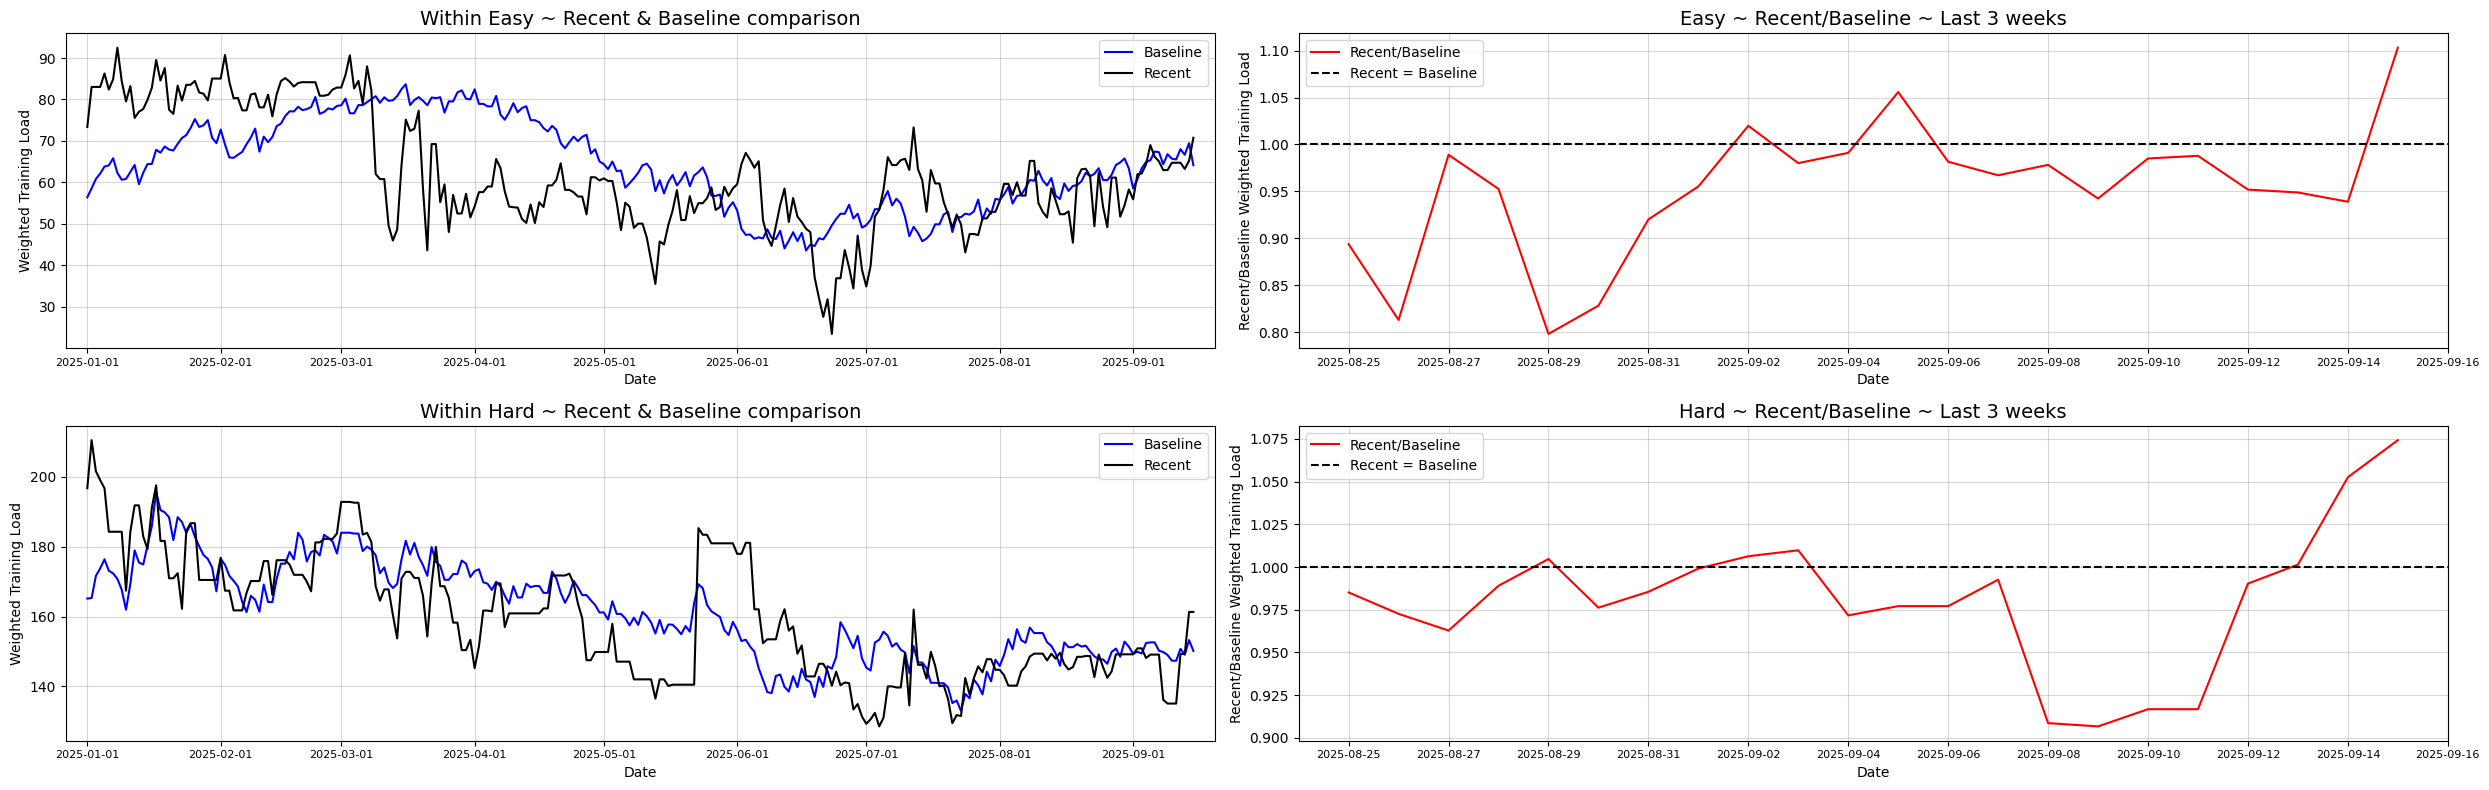

In [57]:
# Between windows bucket level comparison ~ Easy, Hard

fig, ax = plt.subplots(2,2, figsize=(25,8))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0,0].set_title("Within Easy ~ Recent & Baseline comparison", fontsize=14)
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]], color="black", label="Recent")
ax[0,0].set_ylabel("Weighted Training Load")
ax[0,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[0,1].set_title("Easy ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[0,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[0]] / plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[0]], color="red", label="Recent/Baseline")
ax[0,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[0,1].set_ylabel("Recent/Baseline Weighted Training Load")
ax[0,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,0].set_title("Within Hard ~ Recent & Baseline comparison", fontsize=14)
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]], color="blue", label="Baseline")
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]], color="black", label="Recent")
ax[1,0].set_ylabel("Weighted Training Load")
ax[1,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,1].set_title("Hard ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[1,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_VALUE_COLUMN_NAMES[1]] / plot_data_recent[sub_config.BASELINE_SLA_VALUE_COLUMN_NAMES[1]], color="red", label="Recent/Baseline")
ax[1,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[1,1].set_ylabel("Recent/Baseline Weighted Training Load")
ax[1,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlabel("Date")
        ax[i,j].tick_params(axis="x", rotation=0, labelsize=8)
        ax[i,j].legend()
        ax[i,j].grid(alpha=0.5)

plt.tight_layout()
plt.show()

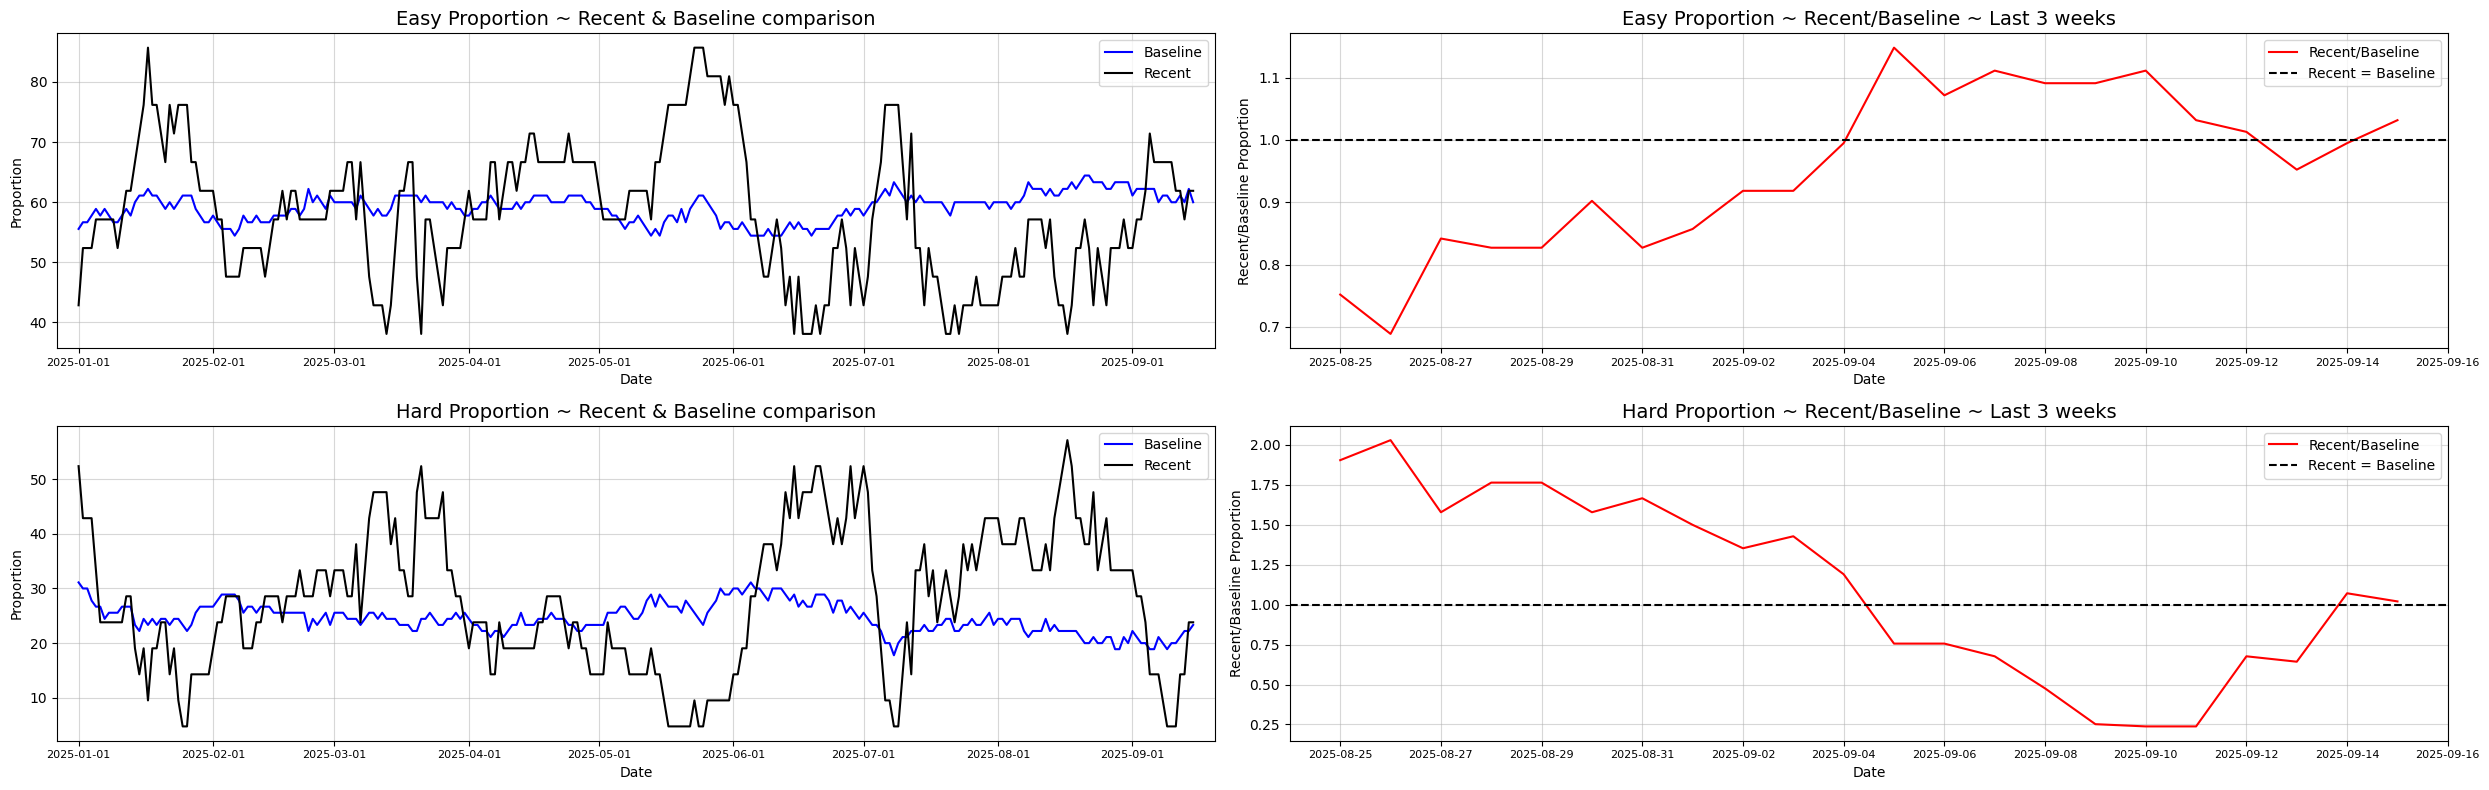

In [58]:
# Between windows bucket proportion comparison ~ Easy, Hard

fig, ax = plt.subplots(2,2, figsize=(25,8))
indices = np.arange(0, len(hasr_tl_data["Datetime"]))
plot_data = hasr_tl_data.loc[hasr_tl_data[sub_config.HASR_TL_COLUMN_NAMES[0]].notnull(), :]
plot_data_recent = plot_data.loc[plot_data["Datetime"] >= plot_data["Datetime"].max() - pd.Timedelta(days=21), :]

ax[0,0].set_title("Easy Proportion ~ Recent & Baseline comparison", fontsize=14)
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[0]], color="blue", label="Baseline")
ax[0,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[0]], color="black", label="Recent")
ax[0,0].set_ylabel("Proportion")
ax[0,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[0,1].set_title("Easy Proportion ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[0,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[0]] / plot_data_recent[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[0]], color="red", label="Recent/Baseline")
ax[0,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[0,1].set_ylabel("Recent/Baseline Proportion")
ax[0,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[0,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,0].set_title("Hard Proportion ~ Recent & Baseline comparison", fontsize=14)
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[1]], color="blue", label="Baseline")
ax[1,0].plot(plot_data["Datetime"], plot_data[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[1]], color="black", label="Recent")
ax[1,0].set_ylabel("Proportion")
ax[1,0].set_xlim(np.min(plot_data["Datetime"]) - datetime.timedelta(days=5), np.max(plot_data["Datetime"] + datetime.timedelta(days=5)))
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())  
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax[1,1].set_title("Hard Proportion ~ Recent/Baseline ~ Last 3 weeks", fontsize=14)
ax[1,1].plot(plot_data_recent["Datetime"], plot_data_recent[sub_config.RECENT_SLA_PROPORTION_COLUMN_NAMES[1]] / plot_data_recent[sub_config.BASELINE_SLA_PROPORTION_COLUMN_NAMES[1]], color="red", label="Recent/Baseline")
ax[1,1].axhline(y=1, color="black", linestyle="--", label="Recent = Baseline")
ax[1,1].set_ylabel("Recent/Baseline Proportion")
ax[1,1].set_xlim(np.min(plot_data_recent["Datetime"]) - datetime.timedelta(days=1), np.max(plot_data_recent["Datetime"] + datetime.timedelta(days=1)))
ax[1,1].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].set_xlabel("Date")
        ax[i,j].tick_params(axis="x", rotation=0, labelsize=8)
        ax[i,j].legend()
        ax[i,j].grid(alpha=0.5)

plt.tight_layout()
plt.show()